## TASK 1 - Blob detection
Group Number: #5

### 1. Data import and preparation

Read an input image from your local directory as grayscale and normalize the values between 0 and 1.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport filters, utils
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
import numpy as np
import filters
import utils
import cv2

# Adjust size of image plot here
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 150

(-0.5, 492.5, 355.5, -0.5)

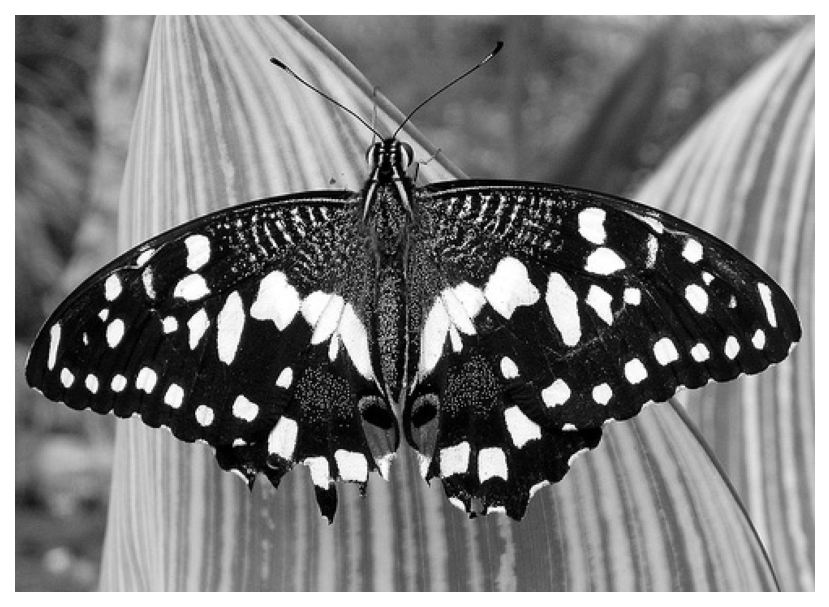

In [2]:
#student_code start
import os

path = "data/butterfly.jpg"

# Load GRAYSCALE directly
img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Convert to float
img_gray = img_gray.astype(np.float64)

plt.imshow(img_gray, cmap="gray")
plt.axis("off")

### 2. Scale Space Creation

Generate the image pyramid using ***get_log_pyramid(..)*** in _filters.py_. Check your results with ***utils.show_plot(..)***

***Submission:*** Save the *third level* of the image scale space of the butterfly as **task1_filtered.png** using ***utils.show_plot(..)***.


sigmas: [ 2.          2.6         3.38        4.394       5.7122      7.42586
  9.653618   12.5497034  16.31461442 21.20899875]


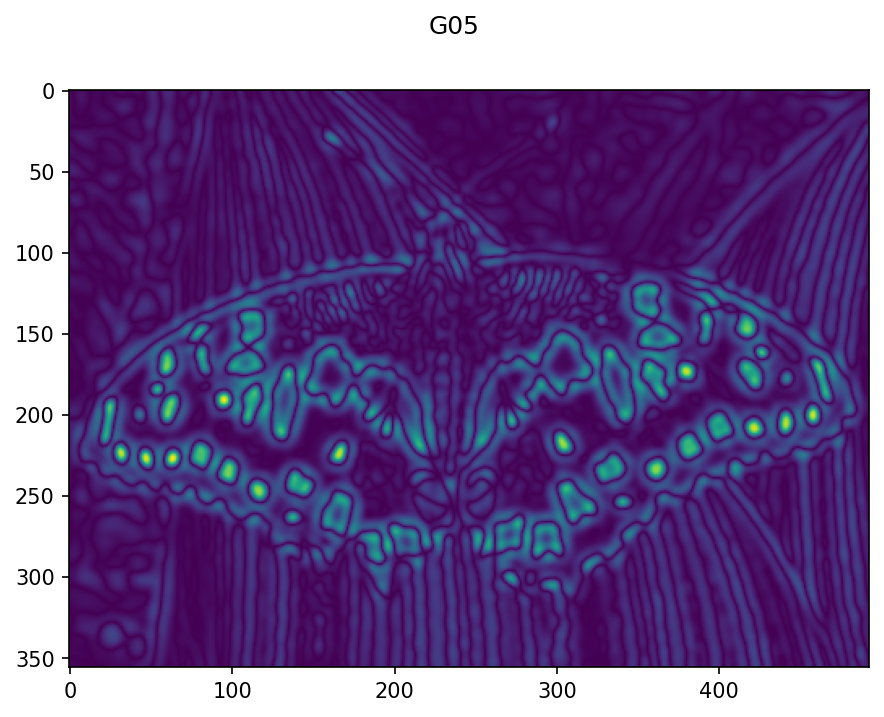

In [13]:
sigma = 2
k = 1.3
levels = 10

#student_code start
from filters import get_log_pyramid
from utils import show_plot

scale_space, all_sigmas = get_log_pyramid(img_gray, sigma, k, levels)

print("sigmas:", all_sigmas)

os.makedirs("results", exist_ok=True)

# third level (index 2)
third_level = scale_space[:, :, 2]

# normalize for nicer visualization
third_level_norm = (third_level - third_level.min()) / (third_level.max() - third_level.min())

group_no = "G05"

show_plot(third_level_norm, group_no=group_no, name="task1_filtered.png")
#student_code end

### 2. Blob detection

Perform the first step of the non-maximum suppression by setting the values in the scale space below a certain threshold to zero. Then, look for maxima in a defined local neighbourhood, in this case: the 26-connection. ***skimage.feature.peak_local_max(..)*** is useful to obtain local maxima. Complete method ***utils.show_blobs(..)*** and plot the blobs.


***Submission:*** Save the image including the blobs as **task1_blobs_full.png** (threshold around 0.3).

Number of peaks: 641


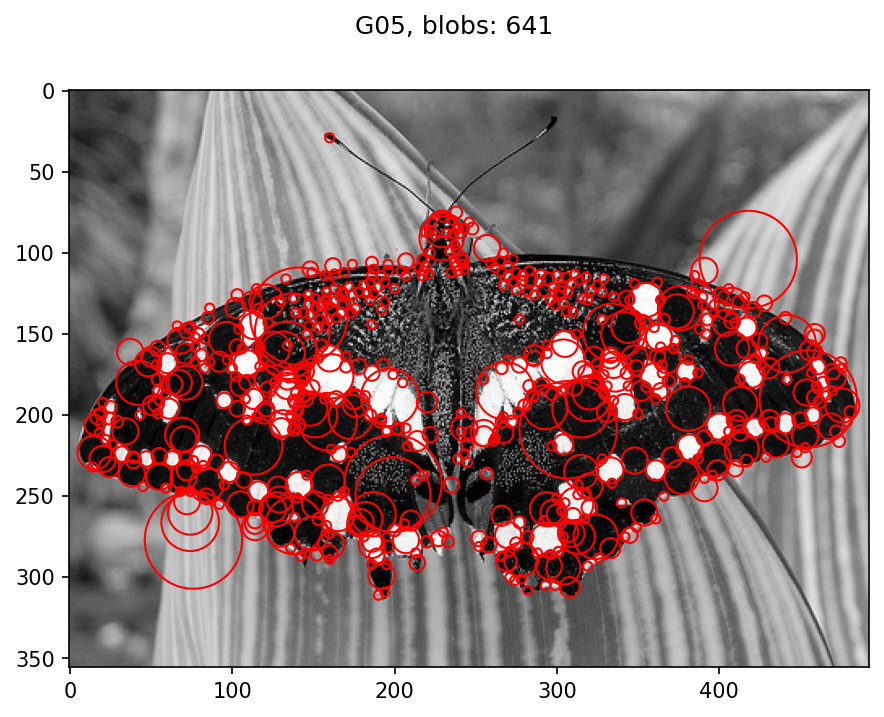

In [14]:
thres = 0.3

#student_code start
from skimage.feature import peak_local_max
from utils import show_blobs

# 1) Optional: normalize the scale space so threshold 0.3 makes sense
scale_space_norm = scale_space / scale_space.max()

# 2) Threshold: set values below t to 0
scale_space_thr = scale_space_norm.copy()
scale_space_thr[scale_space_thr < thres] = 0

# 3) Find local maxima in 3D (26-connected neighborhood)
# footprint of ones(3,3,3) → considers all 26 neighbors around each voxel
peaks = peak_local_max(
    scale_space_thr,
    threshold_abs=thres,
    footprint=np.ones((3, 3, 3)),
    exclude_border=0
)
print("Number of peaks:", len(peaks))

# 4) Make sure results folder exists
os.makedirs("results", exist_ok=True)

# 5) Plot blobs on the original grayscale image and save
group_no = "G05"   # your group number
show_blobs(img_gray, peaks, all_sigmas, group_no=group_no, name="task1_blobs_full.png")

#student_code end


### 3. Evaluation 

Apply the process to a half-sized version of the input image. Plot your results as well with ***utils.show_blobs(..)***.

_***HINT:***_
_cv2.resize(..)_


***Submission:*** Save the result as **task1_blobs_half.png**.

Half image shape: (178, 246)
Number of peaks (half): 240


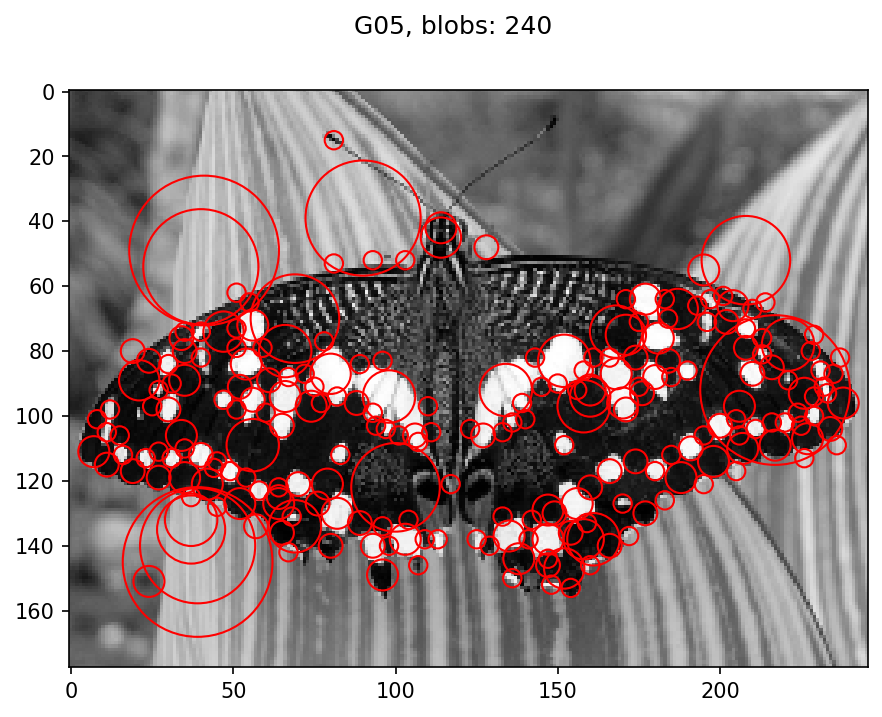

In [15]:
#student_code start
# ----------------------------
# 1) Resize the input image
# ----------------------------
img_half = cv2.resize(img_gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
print("Half image shape:", img_half.shape)

# ----------------------------
# 2) Build LoG scale space for half image
# ----------------------------
scale_space_half, all_sigmas_half = get_log_pyramid(img_half, sigma, k, levels)

# ----------------------------
# 3) Normalize and threshold
# ----------------------------
scale_space_half_norm = scale_space_half / scale_space_half.max()

t = 0.3
scale_space_half_thr = scale_space_half_norm.copy()
scale_space_half_thr[scale_space_half_thr < t] = 0

# ----------------------------
# 4) Detect peaks (26-neighborhood)
# ----------------------------
peaks_half = peak_local_max(
    scale_space_half_thr,
    threshold_abs=t,
    footprint=np.ones((3, 3, 3)),
    exclude_border=0
)
print("Number of peaks (half):", len(peaks_half))

# ----------------------------
# 5) Save visualization
# ----------------------------
show_blobs(img_half, peaks_half, all_sigmas_half,
           group_no="G05", name="task1_blobs_half.png")

#student_code end

In [17]:
print(np.unique(peaks[:,2]))
print(np.unique(peaks_half[:,2]))


[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8]


*** 
#### Taking a close look at the detected blobs on different image scales, is the method able to find blobs in a scale-invariant way? What could be reasons for observed errors or inaccurately detected blobs? 

The results show that the scale-normalized Laplacian of Gaussian detector is largely able to detect blobs in a scale-invariant manner. When the image is resized to half its original dimensions, the same characteristic structures on the butterfly wings are detected, but at proportionally smaller scales, demonstrating correct scale selection. However, some inaccuracies occur due to threshold sensitivity, background texture that produces unintended responses, multiple nearby maxima for the same blob, and the limited number of discrete σ-levels. These factors can lead to missing blobs, duplicated detections, or false positives, especially in regions with strong edges or noise.

#### 3.1 LoG Response

Pick a detected keypoint and plot the response of the LoG for all scales in both image versions. The outcome should be a 2D plot where the x-axis represents the scale of the filter and the y-axis the filter response at the selected keypoint position. 

_***HINT:***_
_plt.plot(..)_

Selected keypoint: (191, 95) scale level: 2


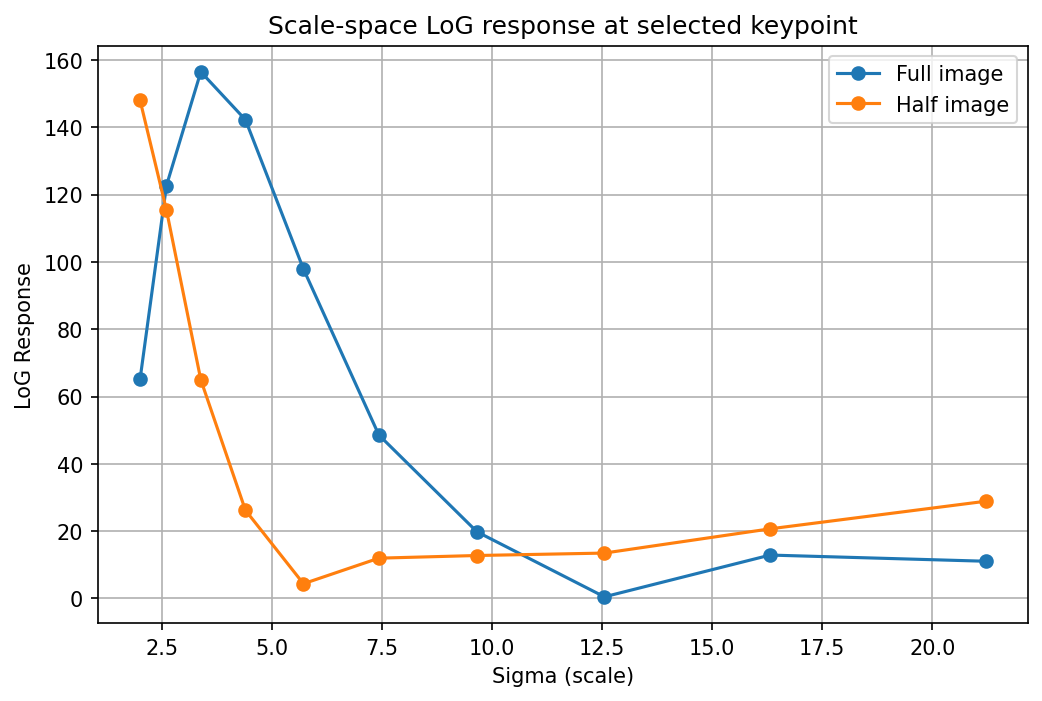

In [18]:
#student_code start
# pick the first detected blob for simplicity
kp = peaks[0]   # [row, col, level]
r, c = kp[0], kp[1]

print("Selected keypoint:", (r, c), "scale level:", kp[2])

# LoG response across scales at selected location
log_values_full = scale_space[r, c, :]    # vector of length (levels)
log_values_half = []

# for half image we must pick a corresponding point:
r_half = int(r * 0.5)
c_half = int(c * 0.5)

log_values_half = scale_space_half[r_half, c_half, :]

plt.figure(figsize=(8, 5))
plt.plot(all_sigmas, log_values_full, marker='o', label='Full image')
plt.plot(all_sigmas_half, log_values_half, marker='o', label='Half image')

plt.xlabel("Sigma (scale)")
plt.ylabel("LoG Response")
plt.title("Scale-space LoG response at selected keypoint")
plt.legend()
plt.grid(True)
plt.show()
#student_code end

*** 
#### Describe and explain the difference between the two LoG response curves.

The LoG response curves of the full-sized and half-sized images exhibit the same general shape, but their peaks occur at different scale levels. In the full-resolution image, the maximum LoG response appears at a larger σ because the underlying blob is physically larger in pixel space. After downscaling the image by a factor of two, the same blob becomes smaller, so its characteristic scale shifts proportionally toward a lower σ value. This shift of the response peak toward smaller scales directly reflects the scale-invariant behavior of the Laplacian-of-Gaussian: the detector consistently identifies the same structure, but at the scale that best matches its new size. Minor differences in curve amplitude or smoothness can arise from interpolation effects during resizing, sampling differences, or the discrete set of σ values used in the scale space.

#### 3.2 Own Image

Import an image of your choice and apply the process once again. 


***Submission:*** Save the image including blobs with ***utils.show_blobs(..)*** as: **task1_blobs_own.png**

Shape: (1821, 1864)
Sigmas: [ 2.          2.6         3.38        4.394       5.7122      7.42586
  9.653618   12.5497034  16.31461442 21.20899875]
Detected blobs: 218


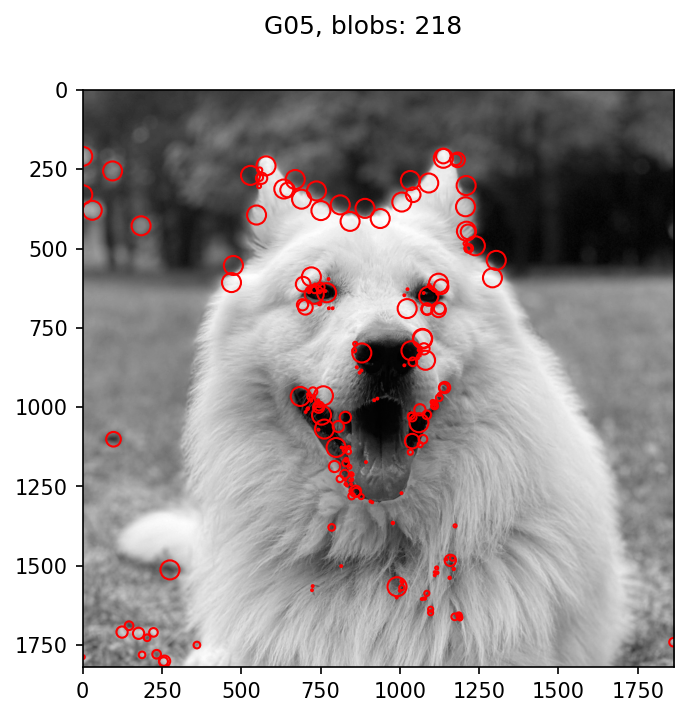

In [ ]:
#student_code start

## LOADING THE IMAGE
path = "data/shepherd.jpeg"
img_gray2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img_gray2 = img_gray2.astype(np.float64)
print("Shape:", img_gray2.shape)


# BUILD LoG SCALE SPACE
sigma = 2
k = 1.3
levels = 10
scale_space2, all_sigmas2 = get_log_pyramid(img_gray2, sigma, k, levels)
print("Sigmas:", all_sigmas2)

# BLOB DETECTION
# Normalize
scale_space2_norm = scale_space2 / scale_space2.max()
# Threshold
t = 0.3
ss2_thr = scale_space2_norm.copy()
ss2_thr[ss2_thr < t] = 0
# 3D peak detection (26-neighborhood)
peaks2 = peak_local_max(
    ss2_thr,
    threshold_abs=t,
    footprint=np.ones((3, 3, 3)),
    exclude_border=0
)

print("Detected blobs:", len(peaks2))
# Create results folder
os.makedirs("results", exist_ok=True)
# Plot & save
show_blobs(img_gray2, peaks2, all_sigmas2,
           group_no="G05", 
           name="task1_blobs_own.png")

#student_code end

Detected blobs (half): 102


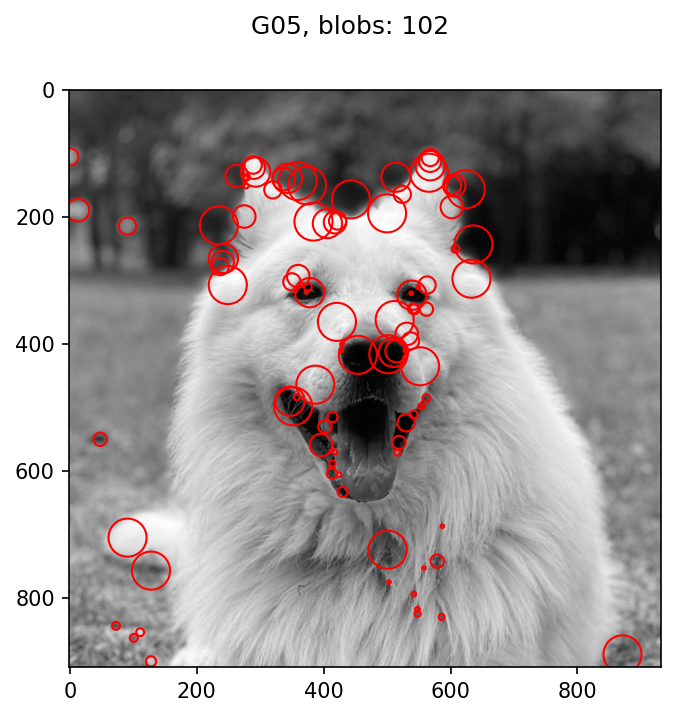

In [25]:
#Student_code start
# Resize to half size
img_half2 = cv2.resize(img_gray2, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

# Build scale space again
scale_space2_half, all_sigmas2_half = get_log_pyramid(img_half2, sigma, k, levels)

# Normalize and threshold
scale_space2_half_norm = scale_space2_half / scale_space2_half.max()
ss2_half_thr = scale_space2_half_norm.copy()
ss2_half_thr[ss2_half_thr < t] = 0

# Peaks
peaks2_half = peak_local_max(
    ss2_half_thr,
    threshold_abs=t,
    footprint=np.ones((3, 3, 3)),
    exclude_border=0
)

print("Detected blobs (half):", len(peaks2_half))

# Save visualization
show_blobs(img_half2, peaks2_half, all_sigmas2_half,
           group_no="G05",
           name="task1_blobs_own_half.png")

#Student_code end